The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Convexidade
:label:`sec_convexity`

A convexidade desempenha um papel vital no projeto de algoritmos de otimização.
Em grande parte, isso se deve ao fato de que é muito mais fácil analisar e testar algoritmos em tal contexto.
Em outras palavras,
se o algoritmo funcionar mal, mesmo na configuração convexa,
normalmente, não devemos esperar ver grandes resultados de outra forma.
Além disso, embora os problemas de otimização no aprendizado profundo sejam geralmente não convexos, eles costumam exibir algumas propriedades dos convexos próximos aos mínimos locais. Isso pode levar a novas variantes de otimização interessantes, como :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`.


In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

## Definições

Antes da análise convexa,
precisamos definir *conjuntos convexos* e *funções convexas*.
Eles levam a ferramentas matemáticas que são comumente aplicadas ao aprendizado de máquina.


### Convex Sets

Os conjuntos são a base da convexidade. Simplificando, um conjunto $\mathcal{X}$ em um espaço vetorial é *convexo* se para qualquer $a, b \in \mathcal{X}$ o segmento de linha conectando $a$ e $b$ também estiver em $\mathcal{X}$. Em termos matemáticos, isso significa que para todos $\lambda \in [0, 1]$ temos

$$\lambda  a + (1-\lambda)  b \in \mathcal{X} \text{ whenever } a, b \in \mathcal{X}.$$

Isso soa um pouco abstrato. Considere :numref:`fig_pacman`. O primeiro conjunto não é convexo, pois existem segmentos de linha que não estão contidos nele.
Os outros dois conjuntos não sofrem esse problema.

![O primeiro conjunto é não convexo e os outros dois são convexos.](http://d2l.ai/_images/pacman.svg)
:label:`fig_pacman`

As definições por si só não são particularmente úteis, a menos que você possa fazer algo com elas.
Neste caso, podemos olhar as interseções como mostrado em :numref:`fig_convex_intersect`.
Suponha que $\mathcal{X}$ e $\mathcal{Y}$ são conjuntos convexos. Então $\mathcal{X} \cap \mathcal{Y}$ também é convexo. Para ver isso, considere qualquer $a, b \in \mathcal{X} \cap \mathcal{Y}$. Como $\mathcal{X}$ e $\mathcal{Y}$ são convexos, os segmentos de linha que conectam $a$ e $b$ estão contidos em $\mathcal{X}$ e $\mathcal{Y}$. Dado isso, eles também precisam estar contidos em $\mathcal{X} \cap \mathcal{Y}$, provando assim nosso teorema.

![A interseção entre dois conjuntos convexos é convexa.](../img/convex-intersect.svg)
:label:`fig_convex_intersect`

Podemos reforçar este resultado com pouco esforço: dados os conjuntos convexos $\mathcal{X}_i$, sua interseção $\cap_{i} \mathcal{X}_i$ é convexa.
Para ver que o inverso não é verdadeiro, considere dois conjuntos disjuntos $\mathcal{X} \cap \mathcal{Y} = \emptyset$. Agora escolha $a \in \mathcal{X}$ e $b \in \mathcal{Y}$. O segmento de linha em :numref:`fig_nonconvex` conectando $a$ e $b$ precisa conter alguma parte que não está em $\mathcal{X}$ nem em $\mathcal{Y}$, uma vez que assumimos que $\mathcal{X} \cap \mathcal{Y} = \emptyset$. Consequentemente, o segmento de linha também não está em $\mathcal{X} \cup \mathcal{Y}$, provando assim que, em geral, as uniões de conjuntos convexos não precisam ser convexas.

![A união de dois conjuntos convexos não precisa ser convexa.](http://d2l.ai/_images/nonconvex.svg)
:label:`fig_nonconvex`

Normalmente, os problemas de aprendizado profundo são definidos em conjuntos convexos. Por exemplo, $\mathbb{R}^d$,
o conjunto de vetores $d$-dimensionais de números reais,
é um conjunto convexo (afinal, a linha entre quaisquer dois pontos em $\mathbb{R}^d$ permanece em $\mathbb{R}^d$). Em alguns casos, trabalhamos com variáveis de comprimento limitado, como bolas de raio $r$ conforme definido por $\{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ e } \|\mathbf{x}\| \leq r\}$.

### Função Convexa

Agora que temos conjuntos convexos, podemos introduzir *funções convexas* $f$.
Dado um conjunto convexo $\mathcal{X}$, uma função $f: \mathcal{X} \to \mathbb{R}$ é *convexa* se para todos $x, x' \in \mathcal{X}$ e para todos $\lambda \in [0, 1]$ temos

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

Para ilustrar isso, vamos representar graficamente algumas funções e verificar quais satisfazem o requisito.
Abaixo definimos algumas funções, convexas e não convexas.


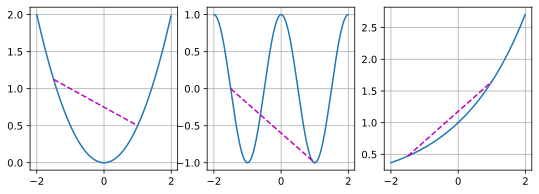

In [2]:
f = lambda x: 0.5 * x**2  # Convex
g = lambda x: torch.cos(np.pi * x)  # Nonconvex
h = lambda x: torch.exp(0.5 * x)  # Convex

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

Como esperado, a função cosseno é *não convexa*, enquanto a parábola e a função exponencial são. Observe que o requisito de que $\mathcal{X}$ seja um conjunto convexo é necessário para que a condição faça sentido. Caso contrário, o resultado de $f(\lambda x + (1-\lambda) x')$ pode não ser bem definido.


### Desigualdades de Jensen

Dada uma função convexa $f$,
uma das ferramentas matemáticas mais úteis
é a *desigualdade de Jensen*.
Isso equivale a uma generalização da definição de convexidade:

$$\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right)    \text{ and }    E_X[f(X)]  \geq f\left(E_X[X]\right),$$

onde $\alpha_i$ são números reais não negativos tais que $\sum_i \alpha_i = 1$ e $X$ é uma variável aleatória.
Em outras palavras, a expectativa de uma função convexa não é menos do que a função convexa de uma expectativa, onde a última é geralmente uma expressão mais simples.
Para provar a primeira desigualdade, aplicamos repetidamente a definição de convexidade a um termo da soma de cada vez.

Uma das aplicações comuns da desigualdade de Jensen é
para ligar uma expressão mais complicada por uma mais simples.
Por exemplo,
sua aplicação pode ser
no que diz respeito ao log-verossimilhança de variáveis aleatórias parcialmente observadas. Ou seja, usamos

$$E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X),$$

uma vez que $\int P(Y) P(X \mid Y) dY = P(X)$.
Isso pode ser usado em métodos variacionais. Aqui $Y$ é normalmente a variável aleatória não observada, $P(Y)$ é a melhor estimativa de como ela pode ser distribuída e $P(X)$ é a distribuição com $Y$ integrada. Por exemplo, no agrupamento $Y$ podem ser os rótulos de cluster e $P(X \mid Y)$ é o modelo gerador ao aplicar rótulos de cluster.

## Propriedades 

As funções convexas têm algumas propriedades úteis. Nós os descrevemos abaixo.


### Mínimos locais são mínimos globais

Em primeiro lugar, os mínimos locais das funções convexas também são os mínimos globais.
Podemos provar isso por contradição como segue.

Considere uma função convexa $f$ definida em um conjunto convexo $\mathcal{X}$.
Suponha que $x^{\ast} \in \mathcal{X}$ seja um mínimo local:
existe um pequeno valor positivo $p$ de forma que para $x \in \mathcal{X}$ que satisfaz $0 < |x - x^{\ast}| \leq p$ temos $f(x^{\ast}) < f(x)$.

Suponha que o mínimo local $x^{\ast}$
não é o mínimo global de $f$:
existe $x' \in \mathcal{X}$ para o qual $f(x') < f(x^{\ast})$. 
Também existe
$\lambda \in [0, 1)$ como $\lambda = 1 - \frac{p}{|x^{\ast} - x'|}$
de modo a
$0 < |\lambda x^{\ast} + (1-\lambda) x' - x^{\ast}| \leq p$. 

Contudo,
de acordo com a definição de funções convexas, temos

$$\begin{aligned}
    f(\lambda x^{\ast} + (1-\lambda) x') &\leq \lambda f(x^{\ast}) + (1-\lambda) f(x') \\
    &< \lambda f(x^{\ast}) + (1-\lambda) f(x^{\ast}) \\
    &= f(x^{\ast}),
\end{aligned}$$

o que contradiz nossa afirmação de que $x^{\ast}$ é um mínimo local.
Portanto, não existe $x' \in \mathcal{X}$ para o qual $f(x') < f(x^{\ast})$. O mínimo local $x^{\ast}$ também é o mínimo global.

Por exemplo, a função convexa $f(x) = (x-1)^2$ tem um mínimo local em $x=1$, que também é o mínimo global.


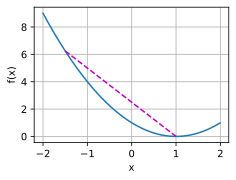

In [3]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

O fato de que os mínimos locais para funções convexas também são os mínimos globais é muito conveniente.
Isso significa que, se minimizarmos as funções, não podemos "ficar presos".
Observe, porém, que isso não significa que não possa haver mais de um mínimo global ou que possa mesmo existir um. Por exemplo, a função $f(x) = \mathrm{max}(|x|-1, 0)$ atinge seu valor mínimo no intervalo $[-1, 1]$. Por outro lado, a função $f(x) = \exp(x)$ não atinge um valor mínimo em $\mathbb{R}$: para $x \to -\infty$ ele assíntotas para $0$, mas não há $x$ para o qual $f(x) = 0$.

### Os conjuntos de funções convexas abaixo são convexos

Nós podemos convenientemente
definir conjuntos convexos
via *conjuntos abaixo* de funções convexas.
Concretamente,
dada uma função convexa $f$ definida em um conjunto convexo $\mathcal{X}$,
qualquer conjunto abaixo

$$\mathcal{S}_b := \{x | x \in \mathcal{X} \text{ and } f(x) \leq b\}$$

é convexo.

Vamos provar isso rapidamente. Lembre-se de que para qualquer $x, x' \in \mathcal{S}_b$ precisamos mostrar que $\lambda x + (1-\lambda) x' \in \mathcal{S}_b$ enquanto $\lambda \in [0, 1]$.
Como $f(x) \leq b$ e $f(x') \leq b$,
pela definição de convexidade, temos

$$f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x') \leq b.$$


### Convexidade e derivados secundários

Sempre que a segunda derivada de uma função $f: \mathbb{R}^n \rightarrow \mathbb{R}$ existe, é muito fácil verificar se $f$ é convexa.
Tudo o que precisamos fazer é verificar se o hessiano de $f$ é semidefinido positivo: $\nabla^2f \succeq 0$, ou seja,
denotando a matriz Hessiana $\nabla^2f$ por $\mathbf{H}$,
$\mathbf{x}^\top \mathbf{H} \mathbf{x} \geq 0$
para todo $\mathbf{x} \in \mathbb{R}^n$.
Por exemplo, a função $f(\mathbf{x}) = \frac{1}{2} \|\mathbf{x}\|^2$ é convexa, pois $\nabla^2 f = \mathbf{1}$, ou seja, seu Hessian é uma matriz de identidade.

Formalmente, qualquer função unidimensional duas vezes diferenciável $f: \mathbb{R} \rightarrow \mathbb{R}$ é convexa
se e somente se sua segunda derivada $f'' \geq 0$. Para qualquer função multidimensional duas vezes diferenciável $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$,
é convexo se e somente se for Hessiano $\nabla^2f \succeq 0$.

Primeiro, precisamos provar o caso unidimensional.
Para ver isso
convexidade de $f$ implica
$f''\geq 0$ usamos o fato de que

$$\frac{1}{2} f(x + \epsilon) + \frac{1}{2} f(x - \epsilon) \geq f\left(\frac{x + \epsilon}{2} + \frac{x - \epsilon}{2}\right) = f(x).$$

Uma vez que a segunda derivada é dada pelo limite sobre diferenças finitas, segue-se que

$$f''(x) = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) + f(x - \epsilon) - 2f(x)}{\epsilon^2} \geq 0.$$

Para ver isso
$f'' \geq 0$ implica que $f$ é convexo
usamos o fato de que $f'' \geq 0$ implica que $f'$ é uma função monotonicamente não decrescente. Sejam $a < x < b$ três pontos em $\mathbb{R}$,
onde $x = (1-\lambda)a + \lambda b$ e $\lambda \in (0, 1)$.
De acordo com o teorema do valor médio,
existem $\alpha \in [a, x]$ e $\beta \in [x, b]$
de tal modo que

$$f'(\alpha) = \frac{f(x) - f(a)}{x-a} \text{ and } f'(\beta) = \frac{f(b) - f(x)}{b-x}.$$

Por monotonicidade  $f'(\beta) \geq f'(\alpha)$, por isso

$$\frac{x-a}{b-a}f(b) + \frac{b-x}{b-a}f(a) \geq f(x).$$

De $x = (1-\lambda)a + \lambda b$,
temos

$$\lambda f(b) + (1-\lambda)f(a) \geq f((1-\lambda)a + \lambda b),$$

provando assim convexidade.

Em segundo lugar, precisamos de um lema antes
comprovando o caso multidimensional:
$f: \mathbb{R}^n \rightarrow \mathbb{R}$
é convexo se e somente se para todos $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$

$$g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y}) \text{ where } z \in [0,1]$$ 

é convexo.

Para provar que a convexidade de $f$ implica que $g$ é convexo,
podemos mostrar que para todos $a, b, \lambda \in [0, 1]$ (portanto
$0 \leq \lambda a + (1-\lambda) b \leq 1$)

$$\begin{aligned} &g(\lambda a + (1-\lambda) b)\\
=&f\left(\left(\lambda a + (1-\lambda) b\right)\mathbf{x} + \left(1-\lambda a - (1-\lambda) b\right)\mathbf{y} \right)\\
=&f\left(\lambda \left(a \mathbf{x} + (1-a)  \mathbf{y}\right)  + (1-\lambda) \left(b \mathbf{x} + (1-b)  \mathbf{y}\right) \right)\\
\leq& \lambda f\left(a \mathbf{x} + (1-a)  \mathbf{y}\right)  + (1-\lambda) f\left(b \mathbf{x} + (1-b)  \mathbf{y}\right) \\
=& \lambda g(a) + (1-\lambda) g(b).
\end{aligned}$$

Para provar o contrário,
nós podemos mostrar isso para
todo$\lambda \in [0, 1]$ 

$$\begin{aligned} &f(\lambda \mathbf{x} + (1-\lambda) \mathbf{y})\\
=&g(\lambda \cdot 1 + (1-\lambda) \cdot 0)\\
\leq& \lambda g(1)  + (1-\lambda) g(0) \\
=& \lambda f(\mathbf{x}) + (1-\lambda) g(\mathbf{y}).
\end{aligned}$$

Finalmente,
usando o lema acima e o resultado do caso unidimensional,
o caso multi-dimensional
pode ser comprovado da seguinte forma.
Uma função multidimensional $f: \mathbb{R}^n \rightarrow \mathbb{R}$ é convexa
se e somente se para todos $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$ $g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z)  \mathbf{y})$, onde $z \in [0,1]$,
é convexo.
De acordo com o caso unidimensional,
isso vale se e somente se
$g'' = (\mathbf{x} - \mathbf{y})^\top \mathbf{H}(\mathbf{x} - \mathbf{y}) \geq 0$ ($\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2f$)
para todo $\mathbf{x}, \mathbf{y} \in \mathbb{R}^n$,
que é equivalente a $\mathbf{H} \succeq 0$
de acordo com a definição de matrizes semidefinidas positivas.



## Restrições

Uma das boas propriedades da otimização convexa é que ela nos permite lidar com as restrições de maneira eficiente. Ou seja, permite-nos resolver problemas da forma:

$$\begin{aligned} \mathop{\mathrm{minimize~}}_{\mathbf{x}} & f(\mathbf{x}) \\
    \text{ subject to } & c_i(\mathbf{x}) \leq 0 \text{ for all } i \in \{1, \ldots, N\}.
\end{aligned}$$

Aqui $f$ é o objetivo e as funções $c_i$ são funções de restrição. Para ver o que isso faz, considere o caso em que $c_1(\mathbf{x}) = \|\mathbf{x}\|_2 - 1$. Neste caso, os parâmetros $\mathbf{x}$ são restritos à bola unitária. Se uma segunda restrição é $c_2(\mathbf{x}) = \mathbf{v}^\top \mathbf{x} + b$, então isso corresponde a todos $\mathbf{x}$  em um meio-espaço. Satisfazer as duas restrições simultaneamente significa selecionar uma fatia de uma bola como o conjunto de restrições.

### Função de Lagrange 

Em geral, resolver um problema de otimização restrito é difícil. Uma maneira de lidar com isso vem da física com uma intuição bastante simples. Imagine uma bola dentro de uma caixa. A bola rolará para o local mais baixo e as forças da gravidade serão equilibradas com as forças que os lados da caixa podem impor à bola. Em suma, o gradiente da função objetivo (ou seja, a gravidade) será compensado pelo gradiente da função de restrição (necessidade de permanecer dentro da caixa em virtude das paredes "empurrando para trás"). Observe que qualquer restrição que não esteja ativa (ou seja, a bola não toca a parede) não será capaz de exercer qualquer força na bola.

Ignorando a derivação da função de Lagrange $L$ (consulte, por exemplo, o livro de Boyd e Vandenberghe para obter detalhes :cite:`Boyd.Vandenberghe.2004`), o raciocínio acima pode ser expresso através do seguinte problema de otimização do ponto de sela:

$$L(\mathbf{x},\alpha) = f(\mathbf{x}) + \sum_i \alpha_i c_i(\mathbf{x}) \text{ where } \alpha_i \geq 0.$$

Aqui, as variáveis $\alpha_i$ são os chamados *Multiplicadores de Lagrange* que garantem que uma restrição seja devidamente aplicada. Eles são escolhidos apenas grandes o suficiente para garantir que $c_i(\mathbf{x}) \leq 0$ para todos os $i$. Por exemplo, para qualquer $\mathbf{x}$ para o qual $c_i(\mathbf{x}) < 0$ naturalmente, acabaríamos escolhendo $\alpha_i = 0$. Além disso, este é um problema de otimização *ponto de sela* em que se deseja *maximizar* $L$ em relação a $\alpha$ e simultaneamente *minimizá-lo* em relação a $\mathbf{x}$. Existe uma vasta literatura explicando como chegar à função $L(\mathbf{x}, \alpha)$. Para nossos propósitos, é suficiente saber que o ponto de sela de $L$ é onde o problema de otimização restrito original é resolvido de forma otimizada.

### Penalidades

Uma maneira de satisfazer problemas de otimização restrita pelo menos aproximadamente é adaptar a função de Lagrange $L$. Em vez de satisfazer $c_i(\mathbf{x}) \leq 0$, simplesmente adicionamos $\alpha_i c_i(\mathbf{x})$ à função objetivo $f(x)$. Isso garante que as restrições não sejam violadas demais.

Na verdade, temos usado esse truque o tempo todo. Considere a diminuição do peso em :numref:`sec_weight_decay`. Nele adicionamos $\frac{\lambda}{2} \|\mathbf{w}\|^2$ à função objetivo para garantir que $\mathbf{w}$ não cresça muito. Usando o ponto de vista da otimização restrita, podemos ver que isso garantirá que $\|\mathbf{w}\|^2 - r^2 \leq 0$ para algum raio $r$. Ajustar o valor de $\lambda$ nos permite variar o tamanho de $\mathbf{w}$.

Em geral, adicionar penalidades é uma boa maneira de garantir a satisfação aproximada da restrição. Na prática, isso acaba sendo muito mais robusto do que a satisfação exata. Além disso, para problemas não convexos, muitas das propriedades que tornam a abordagem exata tão atraente no caso convexo (por exemplo, otimização) não são mais válidas.

### Projeções

Uma estratégia alternativa para satisfazer as restrições são as projeções. Novamente, nós os encontramos antes, por exemplo, ao lidar com recorte de gradiente em :numref:`sec_rnn_scratch`. Lá, garantimos que um gradiente tem comprimento limitado por $c$ via

$$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, c/\|\mathbf{g}\|).$$

Isso acaba sendo uma *projeção* de $g$ na bola de raio $c$. Mais geralmente, uma projeção em um conjunto (convexo) $\mathcal{X}$ é definida como

$$\mathrm{Proj}_\mathcal{X}(\mathbf{x}) = \mathop{\mathrm{argmin}}_{\mathbf{x}' \in \mathcal{X}} \|\mathbf{x} - \mathbf{x}'\|_2.$$

Portanto, é o ponto mais próximo em $\mathcal{X}$ para $\mathbf{x}$. Isso soa um pouco abstrato.  :numref:`fig_projections` explica um pouco mais claramente. Nele temos dois conjuntos convexos, um círculo e um diamante. Os pontos dentro do conjunto (amarelo) permanecem inalterados. Pontos fora do conjunto (preto) são mapeados para o ponto mais próximo dentro do conjunto (vermelho). Enquanto para bolas de $L_2$ isso não altera a direção, este não precisa ser o caso em geral, como pode ser visto no caso do diamante.

![Projeções convexas.](http://d2l.ai/_images/projections.svg)
:label:`fig_projections`

Um dos usos para projeções convexas é calcular vetores de peso esparsos. Neste caso, projetamos $\mathbf{w}$ em uma bola $L_1$ (a última é uma versão generalizada do diamante na imagem acima).

## Sumário

No contexto de aprendizagem profunda, o principal objetivo das funções convexas é motivar algoritmos de otimização e nos ajudar a entendê-los em detalhes. A seguir, veremos como a descida gradiente e a descida gradiente estocástica podem ser derivadas de acordo.

* As interseções de conjuntos convexos são convexas. Os sindicatos não.
* A expectativa de uma função convexa é maior do que a função convexa de uma expectativa (desigualdade de Jensen).
* Uma função duas vezes diferenciável é convexa se, e somente se, sua segunda derivada tem apenas autovalores não negativos em toda a extensão.
* Restrições convexas podem ser adicionadas por meio da função Lagrange. Na prática, basta adicioná-los com uma penalidade à função objetivo.
* As projeções são mapeadas para pontos no conjunto (convexo) mais próximo do ponto original.

## Exercícios

1. Suponha que queremos verificar a convexidade de um conjunto desenhando todas as linhas entre os pontos dentro do conjunto e verificando se as linhas estão contidas.
    1. Prove que é suficiente verificar apenas os pontos no limite.
    1. Prove que é suficiente verificar apenas os vértices do conjunto.
1. Denote por $\mathcal{B}_p[r] := \{\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } \|\mathbf{x}\|_p \leq r\}$  a bola de raio $r$ usando a norma $p$. Prove que $\mathcal{B}_p[r]$ é convexo para todos $p\geq 1$.
1. Dadas as funções convexas $f$ e $g$ mostram que $\mathrm{max} (f, g)$ também é convexo. Prove que $\mathrm{min} (f, g)$ não é convexo.
1. Prove que a normalização da função softmax é convexa. Mais especificamente, provar a convexidade de
    $f(x) = \log \sum_i \exp(x_i)$.
1. Prove que os subespaços lineares são conjuntos convexos, ou seja, $\mathcal{X} = \{\mathbf{x} | \mathbf{W} \mathbf{x} = \mathbf{b}\}$.
1. Prove que no caso de subespaços lineares com $\mathbf{b} = 0$ a projeção $\mathrm{Proj}_\mathcal{X}$ pode ser escrita como $\mathbf{M} \mathbf{x}$ para algumas matrizes $\mathbf{M}$.
1. Mostre que para funções convexas duas vezes diferenciáveis ​​$f$ podemos escrever $f(x + \epsilon) = f(x) + \epsilon f'(x) + \frac{1}{2} \epsilon^2 f''(x + \xi)$ para algum $\xi \in [0, \epsilon]$.
1. Dado um vetor $\mathbf{w} \in \mathbb{R}^d$ com $\|\mathbf{w}\|_1 > 1$, calcule a projeção na bola unitária $\ell_1$.
    1. Como etapa intermediária, escreva o objetivo penalizado $\|\mathbf{w} - \mathbf{w}'\|_2^2 + \lambda \|\mathbf{w}'\|_1$ e calcule a solução para um dado $\lambda > 0$.
    1. Você consegue encontrar o valor 'certo' de $\lambda$ sem muitas tentativas e erros?
1. Dado um conjunto convexo $\mathcal{X}$ e dois vetores $\mathbf{x}$ e $\mathbf{y}$ provam que as projeções nunca aumentam as distâncias, ou seja, $\|\mathbf{x} - \mathbf{y}\| \geq \|\mathrm{Proj}_\mathcal{X}(\mathbf{x}) - \mathrm{Proj}_\mathcal{X}(\mathbf{y})\|$.

[Discussions](https://discuss.d2l.ai/t/350)
<!--stackedit_data:
eyJoaXN0b3J5IjpbOTI5Njc5NDc4LC04NjEwODEwODQsLTE2Mj
g2NTc1NzgsLTE3ODkwOTI5NDksLTIxNDYzMDIzOV19
-->
